In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import cv2
from tqdm import tqdm
from scipy.misc import *
%matplotlib inline

In [108]:
import os
os.getcwd()

'/Users/ritikaagarwal/Documents/DL_Identify_the_product_category'

In [109]:
# Reading the image labels from training and testing dataset

train = pd.read_csv("a0409a00-8-dataset_dp/train.csv")
test = pd.read_csv("a0409a00-8-dataset_dp/test.csv")
print(train.head())

   image_id    label
0  train_1a     rice
1  train_1b    candy
2  train_1c      jam
3  train_1d   coffee
4  train_2a  vinegar


In [110]:
print(test.head())

     image_id
0  test_1000a
1  test_1000b
2  test_1000c
3  test_1000d
4  test_1001a


In [111]:
train.groupby(by = "label").count()

,image_id
label,
beans,88
cake,105
candy,242
cereal,181
chips,118
chocolate,199
coffee,194
corn,63
fish,71


In [112]:
## set the path for images
train_path='a0409a00-8-dataset_dp/train_img/'
test_path='a0409a00-8-dataset_dp/test_img/'

In [113]:
# function to read images as arrays
def read_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    #print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(64,64))
    return img

In [114]:
# Resizing train and test images from 256*256*3to 64X64*3
train_data = []
test_data = []
train_labels = train['label'].values
for img in tqdm(train['image_id'].values):
    train_data.append(read_image(train_path + '{}.png'.format(img)))
    
for img in tqdm(test['image_id'].values):
    test_data.append(read_image(test_path + '{}.png'.format(img)))

100%|██████████| 1732/1732 [00:06<00:00, 262.48it/s]


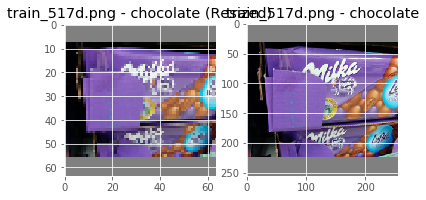

In [115]:
i = np.random.choice(np.arange(len(train_data)))
fig,ax = plt.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title('{}.png - {} (Resized)'.format(train['image_id'].values[i], train_labels[i]))
plt.imshow(train_data[i])

plt.subplot(1,2,2)
plt.title('{}.png - {}'.format(train['image_id'].values[i], train_labels[i]))
plt.imshow(Image.open(train_path +'{}.png'.format(train.image_id[i])))

In [116]:
# Scaling the data
X_train  = np.array(train_data,np.float32) / 255.0
X_test= np.array(test_data,np.float32)/255.0
print(X_train.shape)
print(X_test.shape)

(3215, 64, 64, 3)
(1732, 64, 64, 3)


In [117]:
# Encoding image labels into target variables (categorical)
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
LE = LabelEncoder()
y_train = LE.fit_transform(train_labels)
ohe = OneHotEncoder(categorical_features = 'all')
y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()


In [118]:
print(X_train.shape)
print(y_train.shape)
print(y_train.shape[1])
classes=y_train.shape[1]

(3215, 64, 64, 3)
(3215, 25)
25


In [99]:
print(X_test.shape)

(1732, 64, 64, 3)


In [119]:
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.optimizers import SGD
from keras.preprocessing import image

model= Sequential()
chanDim = -1
# opt= SGD(lr=0.001)

model.add(Conv2D(32, (3, 3), padding="same",input_shape=(64,64,3)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))



In [136]:
# Initializing the optimizer and model

opt = SGD(lr = 0.01,decay=0.01/40,momentum=0.9,nesterov=True)
#opt= SGD(lr=0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [137]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_17 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_18 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
__________

In [138]:

from keras.callbacks import ModelCheckpoint
#fname="weights-{epoch:03d}-{val_loss:.4f}.hdf5"}
fname="weights.best.hdf5"
checkpoint= ModelCheckpoint(fname,monitor="val_loss",mode="min",save_best_only=True,verbose=1)
callbacks=[checkpoint]



In [139]:
# Training the network
print("[INFO] training network..........")
H=model.fit(X_train, y_train, batch_size=64, epochs=40,callbacks=callbacks, validation_split=0.3,verbose=2)

[INFO] training network..........
Train on 2250 samples, validate on 965 samples
Epoch 1/40
Epoch 00000: val_loss improved from inf to 6.69612, saving model to weights.best.hdf5
91s - loss: 1.2829 - acc: 0.6809 - val_loss: 6.6961 - val_acc: 0.2187
Epoch 2/40
Epoch 00001: val_loss improved from 6.69612 to 5.10256, saving model to weights.best.hdf5
87s - loss: 0.6032 - acc: 0.8178 - val_loss: 5.1026 - val_acc: 0.2746
Epoch 3/40
Epoch 00002: val_loss improved from 5.10256 to 4.35255, saving model to weights.best.hdf5
87s - loss: 0.4001 - acc: 0.8751 - val_loss: 4.3525 - val_acc: 0.3016
Epoch 4/40
Epoch 00003: val_loss improved from 4.35255 to 4.04261, saving model to weights.best.hdf5
86s - loss: 0.3186 - acc: 0.8911 - val_loss: 4.0426 - val_acc: 0.3150
Epoch 5/40
Epoch 00004: val_loss improved from 4.04261 to 3.94293, saving model to weights.best.hdf5
86s - loss: 0.2683 - acc: 0.9173 - val_loss: 3.9429 - val_acc: 0.3244
Epoch 6/40
Epoch 00005: val_loss did not improve
86s - loss: 0.2023 

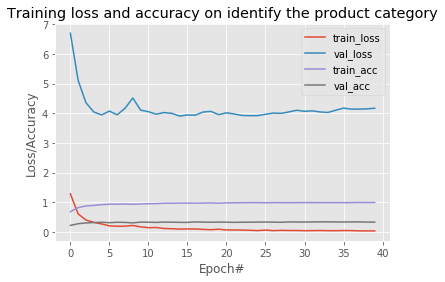

In [140]:
#plot the training loss and accuracy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,40),H.history["loss"],label="train_loss")
plt.plot(np.arange(0,40),H.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,40),H.history["acc"],label="train_acc")
plt.plot(np.arange(0,40),H.history["val_acc"],label="val_acc")
plt.title("Training loss and accuracy on identify the product category")
plt.xlabel("Epoch#")
plt.ylabel("Loss/Accuracy")
plt.legend()
#plt.savefig(args["output"])                  

In [141]:
# Making predictions on test set
predictions = model.predict(X_test,batch_size=64)
predictions = np.argmax(predictions, axis= 1)

In [143]:
from sklearn.metrics import classification_report
#print(classification_report(.argmax(axis=1),predictions.argmax(axis=1), target_names=labelNames))

In [144]:
predictions[13:21]

array([13,  0,  2, 11, 12,  2, 22, 12])

In [145]:
unique_labels = np.unique(train['label'].tolist())

In [146]:
print(unique_labels)

['beans' 'cake' 'candy' 'cereal' 'chips' 'chocolate' 'coffee' 'corn'
 'fish' 'flour' 'honey' 'jam' 'juice' 'milk' 'nuts' 'oil' 'pasta' 'rice'
 'soda' 'spices' 'sugar' 'tea' 'tomatosauce' 'vinegar' 'water']


In [147]:
# Converting predicted category numbers to predicted labels
pred_labels = unique_labels[predictions]
print(pred_labels)

['candy' 'chocolate' 'oil' ... 'tea' 'honey' 'candy']


I see this product is oil


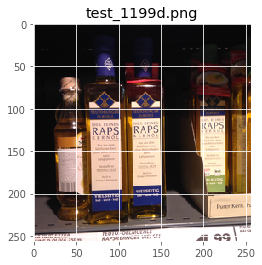

In [153]:
## lets see what our classifier predicts on random test images
# Random predictions
i = np.random.choice(np.arange(len(test_data)))
print('I see this product is {}'.format(pred_labels[i]))
plt.title('{}.png'.format(test['image_id'].values[i]))
plt.imshow(Image.open(test_path +'{}.png'.format(test.image_id[i])))